# Tutorial 


In this tutorial, we will demonstrate how to use FinerCAM step by step.  



First, lets prepare our model

In [2]:
import torch
import torch.nn as nn
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
from pytorch_grad_cam import GradCAM,LayerCAM,ScoreCAM,GradCAMPlusPlus,XGradCAM,FinerCAM
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt

In [3]:
class ModifiedDINO(nn.Module):
    """
    A wrapper for the original DINO model that adds a classifier layer.
    """
    def __init__(self, original_model, classifier_path, num_classes, feature_dim=768):
        super(ModifiedDINO, self).__init__()
        self.original_model = original_model
        self.classifier = nn.Linear(feature_dim, num_classes)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.classifier.load_state_dict(
            torch.load(classifier_path, map_location=device)
        )
        self.blocks = self.original_model.blocks
        print("ModifiedDINO initialized")

    def forward(self, x):
        features = self.original_model.forward_features(x)["x_norm_patchtokens"]
        features = features.mean(dim=1)
        logits = self.classifier(features)
        return logits

In [4]:
original_model = torch.hub.load(
    'facebookresearch/dinov2', 'dinov2_vitb14', pretrained=True
).to('cuda')
num_classes = 525
model = ModifiedDINO(original_model, '/home/zhang.13617/Desktop/Finer-CAM/classifier_weight/classifier_birds_DINO.pth', num_classes)
model = model.to('cuda')

Using cache found in /home/zhang.13617/.cache/torch/hub/facebookresearch_dinov2_main
/home/zhang.13617/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/zhang.13617/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/zhang.13617/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


ModifiedDINO initialized


 Bring the channels to the first dimension, like in CNNs.

In [5]:
def reshape_transform(tensor, height=16, width=16):
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result

Ensuring image's dimensions align with the patch size.
Here, you could also simply preprocess the image to 224x224

In [6]:
def preprocess(image, patch_size=14, max_size=1000):
    image = image.convert("RGB")
    width, height = image.size

    if max(width, height) > max_size:
        scale = max_size / max(width, height)
        width = int(width * scale)
        height = int(height * scale)
        image = image.resize((width, height), Image.BICUBIC)

    new_height_pixels = int(np.ceil(height / patch_size) * patch_size)
    new_width_pixels = int(np.ceil(width / patch_size) * patch_size)

    transform = Compose([
        Resize((new_height_pixels, new_width_pixels), interpolation=Image.BICUBIC),
        ToTensor(),
        Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                  std=[0.26862954, 0.26130258, 0.27577711]),
    ])

    image_tensor = transform(image).to(torch.float32)
    
    grid_height = new_height_pixels // patch_size
    grid_width = new_width_pixels // patch_size
    
    return image_tensor, grid_height, grid_width


In [9]:
image = Image.open('/home/zhang.13617/Desktop/Finer-CAM/imgs/BLUE_GROSBEAK.jpg').convert('RGB')
original_width, original_height = image.size
image_tensor, grid_h, grid_w = preprocess(image)
image_tensor = image_tensor.unsqueeze(0).to('cuda')
image = np.array(image, dtype=np.float32)/255

Lets define the target function and the target layer, and create the visualizations:



- The only difference when creating a FinerCAM instance is the need to select a baseline method.
- Here, alpha represents the contrast intensity. When alpha = 0, FinerCAM degrades to the baseline method.

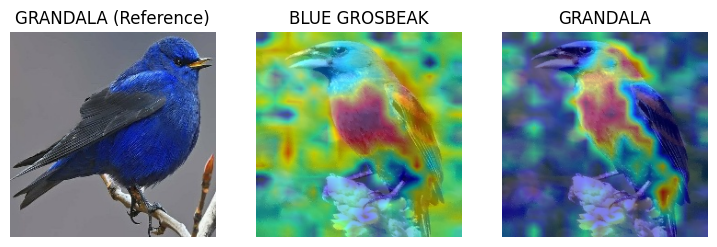

In [12]:
target_layers = [model.blocks[-1].norm1]
cam = FinerCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform, base_method=GradCAM)

# CAM for BLUE GROSBEAK
grayscale_cam_98 = cam(
    input_tensor=image_tensor,
    targets=None,
    target_idx=98,
    alpha=0
)

grayscale_cam_98 = grayscale_cam_98[0, :]
grayscale_cam_highres_98 = cv2.resize(grayscale_cam_98, (original_width, original_height))
cam_image_98 = show_cam_on_image(image, grayscale_cam_highres_98, use_rgb=True)

# CAM for GRANDALA 
grayscale_cam_248 = cam(
    input_tensor=image_tensor,
    targets=None,
    target_idx=248,
    alpha=0
)

grayscale_cam_248 = grayscale_cam_248[0, :]
grayscale_cam_highres_248 = cv2.resize(grayscale_cam_248, (original_width, original_height))
cam_image_248 = show_cam_on_image(image, grayscale_cam_highres_248, use_rgb=True)

grandala_ref_image = cv2.imread("/home/zhang.13617/Desktop/Finer-CAM/imgs/GRANDALA.jpg")
grandala_ref_image = cv2.cvtColor(grandala_ref_image, cv2.COLOR_BGR2RGB) 
fig, axes = plt.subplots(1, 3, figsize=(9, 3)) 

axes[0].imshow(grandala_ref_image)
axes[0].set_title("GRANDALA (Reference)")
axes[0].axis("off")

axes[1].imshow(cam_image_98)
axes[1].set_title("BLUE GROSBEAK")
axes[1].axis("off")

axes[2].imshow(cam_image_248)
axes[2].set_title("GRANDALA")
axes[2].axis("off")

plt.show()


The blue belly is indeed an important feature, but it is not **discriminative** for distinguishing between categories.

Let's see how Finer-CAM works

In [13]:
from pytorch_grad_cam.utils.model_targets import FinerWeightedTarget

For Finer-Target, we can specify a **main category** as an integer and a list of **comparison categories**. In this case, we compare against only one category.

In [14]:
targets = [FinerWeightedTarget(main_category = 98,comparison_categories= [248], alpha =1 )]

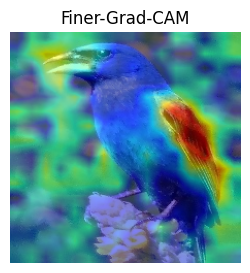

In [16]:
grayscale_cam_finer= cam(
    input_tensor=image_tensor,
    targets=targets,
)

grayscale_cam_finer = grayscale_cam_finer[0, :]
grayscale_cam_highres_finer = cv2.resize(grayscale_cam_finer, (original_width, original_height))
cam_image_finer = show_cam_on_image(image, grayscale_cam_highres_finer, use_rgb=True)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(cam_image_finer)
ax.set_title("Finer-Grad-CAM")
ax.axis("off")

plt.show()

Note: when target_idx and targets are not explicitly specified, FinerCAM will automatically select the highest probability category and compare it with the three most similar categories.

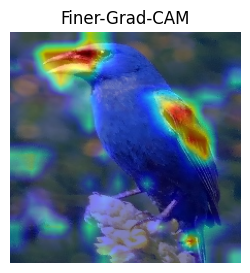

In [17]:
grayscale_cam_finer= cam(
    input_tensor=image_tensor,
    targets = None,
)

grayscale_cam_finer = grayscale_cam_finer[0, :]
grayscale_cam_highres_finer = cv2.resize(grayscale_cam_finer, (original_width, original_height))
cam_image_finer = show_cam_on_image(image, grayscale_cam_highres_finer, use_rgb=True)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(cam_image_finer)
ax.set_title("Finer-Grad-CAM")
ax.axis("off")

plt.show()

Also, Finer-CAM accept all gradient/score based CAM method as baseline.

Here is a example of **Finer-Score-CAM**

  0%|          | 0/48 [00:00<?, ?it/s]

100%|██████████| 48/48 [00:03<00:00, 13.60it/s]


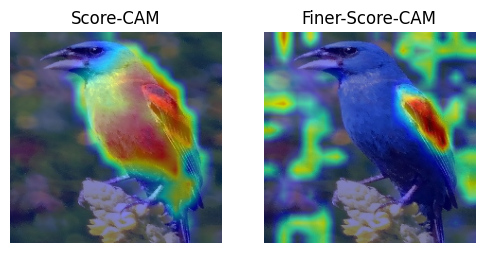

In [18]:
import cv2
import matplotlib.pyplot as plt

cam = FinerCAM( model=model, target_layers=target_layers, reshape_transform=reshape_transform, base_method = ScoreCAM)
grayscale_cam_finer= cam(
    input_tensor=image_tensor,
    targets=None,
)

grayscale_cam_finer = grayscale_cam_finer[0, :]
grayscale_cam_highres_finer = cv2.resize(grayscale_cam_finer, (original_width, original_height))
cam_image_finer = show_cam_on_image(image, grayscale_cam_highres_finer, use_rgb=True)

grayscale_cam_finer_alpha0= cam(
    input_tensor=image_tensor,
    targets=None,
    alpha=0  # degrades to ScoreCAM
)

grayscale_cam_finer_alpha0 = grayscale_cam_finer_alpha0[0, :]
grayscale_cam_highres_finer_alpha0 = cv2.resize(grayscale_cam_finer_alpha0, (original_width, original_height))
cam_image_finer_alpha0 = show_cam_on_image(image, grayscale_cam_highres_finer_alpha0, use_rgb=True)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].imshow(cam_image_finer_alpha0)
axes[0].set_title("Score-CAM")
axes[0].axis("off")

axes[1].imshow(cam_image_finer)
axes[1].set_title("Finer-Score-CAM")
axes[1].axis("off")

plt.show()